### By Vaasudevan Srinivasan ([vaasudevans.github.io](https://vaasudevans.github.io))
Created: April 9, 2019

Modified : April 11, 2019

In [0]:
# Download the datasets

# IRIS dataset
!wget https://raw.githubusercontent.com/VaasuDevanS/SVM-in-RemoteSensing/master/Implementation/iris-data.txt -qO iris-data.txt

# SVM for satellite imagery    
!wget https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Images/original.tif?raw=true -qO "original.tif"
!wget https://github.com/VaasuDevanS/SVM-in-RemoteSensing/blob/master/Implementation/Images/training.tif?raw=true -qO "training.tif"

## SVM for Iris dataset (presentation talk)

In [0]:
# Import the modules

from sklearn import svm, model_selection as ms
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import *
import matplotlib.pyplot as plt
import pandas as pd

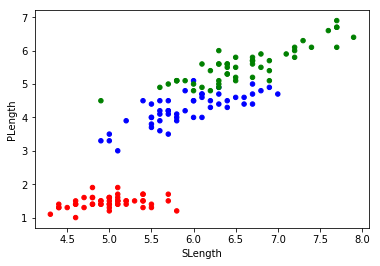

In [44]:
# Load the Dataset

cols = ["SLength", "SWidth", "PLength", "PWidth", "Class"]
types = ["Setosa", "Versicolor", "Virginica"]
iris = pd.read_csv("iris-data.txt", sep="\t", names=cols)


# Plot the values (plotting is done via pandas)

colors = [{1:'red', 2:'blue', 3:'green'}[i] for i in iris.Class]
iris.plot.scatter(x='SLength', y='PLength', c=colors)

In [0]:
# Split the Dataset into Training and Testing

iris_len = pd.DataFrame([iris.SLength, iris.PLength, iris.Class]).transpose()
train, test = ms.train_test_split(iris_len, test_size=0.3, random_state=1)
cTrain, cTest = train.pop('Class'), test.pop('Class')

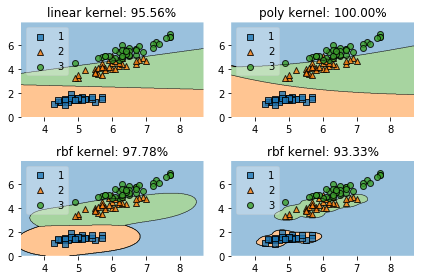

In [51]:
# Test the trained model with various SVM models and visualize them

for params,p in [({'kernel': 'linear', 'C': 1.0}, 221),
                 ({'kernel': 'poly', 'gamma': 0.1}, 222),
                 ({'kernel': 'rbf', 'gamma': 1}, 223),
                 ({'kernel': 'rbf', 'gamma': 20}, 224)
                ]:
    
    # Classifier
    clf = svm.SVC(**params)
    clf.fit(train, cTrain)

    # Predict
    accuracy = accuracy_score(cTest, clf.predict(test)) *100

    # Visualise the Hyper-plane
    X, Y = train.values, cTrain.values.astype(pd.np.integer)
    
    ttl = "%s kernel: %.2f%%" % (params['kernel'], accuracy)
    plt.subplot(p)
    plt.title(ttl)
    plot_decision_regions(X=X, y=Y, clf=clf, legend=2)
    
plt.tight_layout()
plt.show()

## SVM for Imagery using sklearn

In [0]:
# Importing the modules

import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import gdal

In [0]:
# Linux command to display the MetaData of the data
!gdalinfo original.tif -nomd

# Load the dataset
ds = gdal.Open("original.tif")
imgArr = np.zeros((ds.RasterXSize, ds.RasterYSize, ds.RasterCount), np.int16)
for band in range(ds.RasterCount):
    imgArr[:,:,band] = ds.GetRasterBand(band+1).ReadAsArray() 

# Load the Training classe Image
train_ds = gdal.Open("training.tif")
trainArr = train_ds.GetRasterBand(1).ReadAsArray()

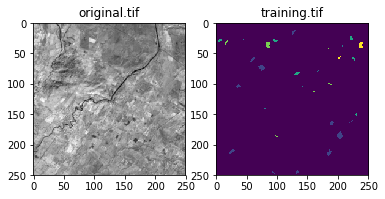

In [0]:
# Visualize the images

plt.subplot(121)
plt.imshow(imgArr[:,:,3], cmap='gray') # cv2
plt.title("original.tif")

plt.subplot(122)
plt.imshow(trainArr)
plt.title("training.tif")
plt.show()

In [0]:
# Prepare the Dataset for Training

mask = trainArr>0
modelX = imgArr[mask]
modelY = trainArr[mask]
print(modelX.shape, modelY.shape)

(718, 8) (718,)


In [0]:
# Train the SVM Linear model

clf = svm.SVC(kernel="linear")
clf.fit(modelX, modelY)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = modelY
df['predict'] = clf.predict(modelX)

print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5  All
truth                              
1        383   0    0    0   0  383
2          0  16    0    0   0   16
3          0   0  145    0   0  145
4          0   0    0   98   8  106
5          0   0    0    5  63   68
All      383  16  145  103  71  718
